In [32]:
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
with h5py.File('data/BD-healthy.hdf5', 'r') as f:
    # loading actions taken by the subjects
    action = f['action'][:].astype(np.int32)
    
    # loading rewards received by the subjects
    reward = f['reward'][:].astype(np.float32)
    
# generating test and training data
action_train, action_test, reward_train, reward_test = train_test_split(action, reward, test_size=0.2)

In [4]:
def run_sim(alpha, beta, n_trials):
    """Rescorla-Wagner 모델을 사용하여 한 명의 참가자 데이터를 시뮬레이션합니다."""
    reward_probs = [0.8, 0.2]
    q_values = np.zeros(2)
    actions = np.zeros(n_trials, dtype=int)
    rewards = np.zeros(n_trials, dtype=int)
    for t in range(n_trials):
        scaled_q = beta * (q_values - np.max(q_values))
        probs = np.exp(scaled_q) / np.sum(np.exp(scaled_q))
        action = np.random.choice([0, 1], p=probs)
        reward = np.random.binomial(1, reward_probs[action])
        prediction_error = reward - q_values[action]
        q_values[action] += alpha * prediction_error
        actions[t], rewards[t] = action, reward
    return actions, rewards

In [6]:

# --------------------------------------------------------------------------
# 1. RNN 모델을 위한 데이터 준비
# --------------------------------------------------------------------------
# TensorFlow 코드의 전처리 로직을 PyTorch에 맞게 구현합니다.
# 입력(X): t-1 시점의 [보상, 행동(원-핫)]
# 타겟(Y): t 시점의 [행동(원-핫)]

def prepare_data_for_rnn(actions, rewards, n_actions=2):
    """
    행동/보상 시퀀스를 RNN 입/출력 텐서로 변환합니다.
    -1로 코딩된 누락된 시행을 올바르게 처리합니다.

    Args:
        actions (np.array): (S, T) 크기의 행동 배열
        rewards (np.array): (S, T) 크기의 보상 배열
        n_actions (int): 총 행동의 가짓수

    Returns:
        tuple: (입력 텐서, 타겟 텐서, 유효 시행 마스크)
    """
    actions_tensor = torch.tensor(actions, dtype=torch.long)
    
    # -1 인덱스 오류를 피하기 위한 처리
    invalid_trials_mask = (actions_tensor == -1)
    
    # one_hot 함수에 넣기 위해 -1을 임시로 0으로 변경
    actions_tensor_temp = actions_tensor.clone()
    actions_tensor_temp[invalid_trials_mask] = 0 # Replace -1 with a valid index
    
    # 행동을 원-핫 인코딩으로 변환
    action_onehot = torch.nn.functional.one_hot(actions_tensor_temp, num_classes=n_actions)
    
    # 원래 -1이었던 위치의 원-핫 벡터를 [0, 0, ...]으로 설정
    action_onehot[invalid_trials_mask] = 0
    
    # 보상 배열의 차원을 (S, T, 1)로 변경
    rewards_tensor = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
    
    # 보상과 행동을 결합하여 (S, T, 1 + n_actions) 크기의 텐서 생성
    reward_action = torch.cat([rewards_tensor, action_onehot.float()], dim=2)
    
    # TensorFlow의 ZeroPadding1D(padding=[1, 0])와 동일한 기능 구현
    padding = torch.zeros(reward_action.shape[0], 1, reward_action.shape[2])
    x_tensor = torch.cat([padding, reward_action], dim=1)[:, :-1, :]
    
    # 타겟(y)은 현재 시점의 행동(원-핫)입니다.
    y_tensor = action_onehot
    
    # 유효한(non -1) 시행에 대한 마스크를 반환
    valid_mask = ~invalid_trials_mask
    
    return x_tensor, y_tensor, valid_mask

x_train, y_train, mask_train = prepare_data_for_rnn(action_train, reward_train)
x_test, y_test, mask_test = prepare_data_for_rnn(action_test, reward_test)

print(f"\nRNN 데이터 준비 완료.")
print(f"x_train shape: {x_train.shape}") # (S, T, n_features)
print(f"y_train shape: {y_train.shape}") # (S, T, n_actions)



RNN 데이터 준비 완료.
x_train shape: torch.Size([326, 183, 3])
y_train shape: torch.Size([326, 183, 2])


In [22]:
# --------------------------------------------------------------------------
# 2. PyTorch RNN 모델 정의
# --------------------------------------------------------------------------

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, initial_state=None):
        gru_out, final_state = self.gru(x, initial_state)
        policy = torch.softmax(self.fc(gru_out), dim=-1)
        return policy, final_state

# 모델 파라미터
n_actions = 2
input_dim = 1 + n_actions
hidden_dim = 5
output_dim = n_actions

# 모델, 손실 함수, 옵티마이저 초기화
model = RNNModel(input_dim, hidden_dim, output_dim)
criterion = nn.BCELoss(reduction='none') # 각 원소별 손실을 계산하도록 설정
optimizer = optim.Adam(model.parameters(), lr=1e-2)

print(f"\nPyTorch 모델 생성 완료:\n{model}")



PyTorch 모델 생성 완료:
RNNModel(
  (gru): GRU(3, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=2, bias=True)
)


In [26]:
batch_size

326

In [23]:
# --------------------------------------------------------------------------
# 3. 모델 학습
# --------------------------------------------------------------------------
n_epochs = 1000
batch_size = x_train.shape[0]

print("\n모델 학습 시작...")
for epoch in range(n_epochs):
    model.train()
    
    initial_rnn_state = torch.zeros(x_train.shape[0], hidden_dim)
    
    # 순전파
    y_pred, _ = model(x_train, initial_rnn_state.unsqueeze(0))
    
    # 손실 계산 (유효한 시행에 대해서만)
    loss_all_elements = criterion(y_pred, y_train.float()) # Shape: (S, T, C)
    trial_loss = torch.sum(loss_all_elements, dim=2) # Shape: (S, T)
    
    masked_trial_loss = trial_loss * mask_train.float()
    
    num_valid_trials = torch.sum(mask_train)
    loss = torch.sum(masked_trial_loss) / num_valid_trials if num_valid_trials > 0 else torch.tensor(0.0)
    
    # 역전파 및 파라미터 업데이트
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            # 정확도 계산 (유효한 시행에 대해서만)
            y_pred_valid = y_pred[mask_train]
            y_train_valid = y_train[mask_train]
            
            correct_preds = torch.sum(torch.argmax(y_pred_valid, dim=1) == torch.argmax(y_train_valid, dim=1))
            total_valid_preds = y_train_valid.shape[0]
            accuracy = (correct_preds.float() / total_valid_preds) * 100 if total_valid_preds > 0 else 0.0
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')

print("모델 학습 완료.")



모델 학습 시작...
Epoch [10/1000], Loss: 1.2625, Accuracy: 86.18%
Epoch [20/1000], Loss: 1.0316, Accuracy: 87.63%
Epoch [30/1000], Loss: 0.7985, Accuracy: 88.80%
Epoch [40/1000], Loss: 0.6642, Accuracy: 85.34%
Epoch [50/1000], Loss: 0.6257, Accuracy: 85.71%
Epoch [60/1000], Loss: 0.6008, Accuracy: 89.94%
Epoch [70/1000], Loss: 0.5902, Accuracy: 89.94%
Epoch [80/1000], Loss: 0.5814, Accuracy: 89.94%
Epoch [90/1000], Loss: 0.5723, Accuracy: 89.94%
Epoch [100/1000], Loss: 0.5643, Accuracy: 89.94%
Epoch [110/1000], Loss: 0.5564, Accuracy: 89.88%
Epoch [120/1000], Loss: 0.5483, Accuracy: 89.94%
Epoch [130/1000], Loss: 0.5407, Accuracy: 90.55%
Epoch [140/1000], Loss: 0.5346, Accuracy: 91.78%
Epoch [150/1000], Loss: 0.5301, Accuracy: 92.03%
Epoch [160/1000], Loss: 0.5269, Accuracy: 92.14%
Epoch [170/1000], Loss: 0.5244, Accuracy: 92.15%
Epoch [180/1000], Loss: 0.5223, Accuracy: 92.14%
Epoch [190/1000], Loss: 0.5203, Accuracy: 92.13%
Epoch [200/1000], Loss: 0.5185, Accuracy: 92.14%
Epoch [210/1000]

In [27]:
# --------------------------------------------------------------------------
# 4. 모델 평가
# --------------------------------------------------------------------------
model.eval()
with torch.no_grad():
    initial_rnn_state_test = torch.zeros(x_test.shape[0], hidden_dim)
    y_pred_test, _ = model(x_test, initial_rnn_state_test.unsqueeze(0))
    
    # 테스트 데이터에 대한 손실 계산
    test_loss_all_elements = criterion(y_pred_test, y_test.float())
    test_trial_loss = torch.sum(test_loss_all_elements, dim=2)
    masked_test_trial_loss = test_trial_loss * mask_test.float()
    num_valid_test_trials = torch.sum(mask_test)
    test_loss = torch.sum(masked_test_trial_loss) / num_valid_test_trials if num_valid_test_trials > 0 else torch.tensor(0.0)
    
    # 테스트 데이터에 대한 정확도 계산
    y_pred_test_valid = y_pred_test[mask_test]
    y_test_valid = y_test[mask_test]
    correct_preds_test = torch.sum(torch.argmax(y_pred_test_valid, dim=1) == torch.argmax(y_test_valid, dim=1))
    total_valid_test_preds = y_test_valid.shape[0]
    test_accuracy = (correct_preds_test.float() / total_valid_test_preds) * 100 if total_valid_test_preds > 0 else 0.0

print(f"\n테스트 데이터 평가 결과:")
print(f"Loss: {test_loss.item():.4f}, Accuracy: {test_accuracy:.2f}%")




테스트 데이터 평가 결과:
Loss: 0.5347, Accuracy: 90.34%



오프-폴리시 시뮬레이션 시작...


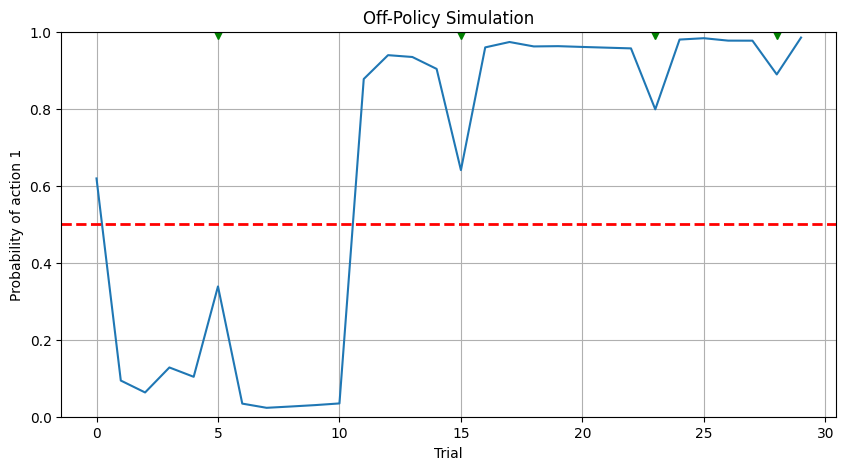

In [28]:

# --------------------------------------------------------------------------
# 5. 오프-폴리시(Off-policy) 모델 시뮬레이션
# --------------------------------------------------------------------------
print("\n오프-폴리시 시뮬레이션 시작...")
model.eval()
with torch.no_grad():
    sim_actions = np.array([0] * 10 + [1] * 20)
    sim_rewards = np.zeros(30)
    sim_rewards[[4, 14, 22, 27]] = 1
    
    x_sim, _, _ = prepare_data_for_rnn(sim_actions[np.newaxis, :], sim_rewards[np.newaxis, :])
    
    initial_state_sim = torch.zeros(1, hidden_dim)
    
    policy_sim, _ = model(x_sim, initial_state_sim.unsqueeze(0))
    
    plt.figure(figsize=(10, 5))
    plt.ylim((0, 1))
    plt.xlabel('Trial')
    plt.ylabel('Probability of action 1')
    plt.title('Off-Policy Simulation')
    plt.plot(np.arange(policy_sim.shape[1]), policy_sim.squeeze()[:, 1].numpy())
    plt.axhline(y=0.5, linewidth=2, color='red', linestyle="--")
    for r_idx in [4, 14, 22, 27]:
        plt.plot(r_idx + 1, 1, marker="v", color='green', markersize=10)
    plt.grid(True)
    plt.show()


온-폴리시 시뮬레이션 시작...
On-policy 시뮬레이션 200회 시행 후 행동 1 선택 확률 평균: 0.4086


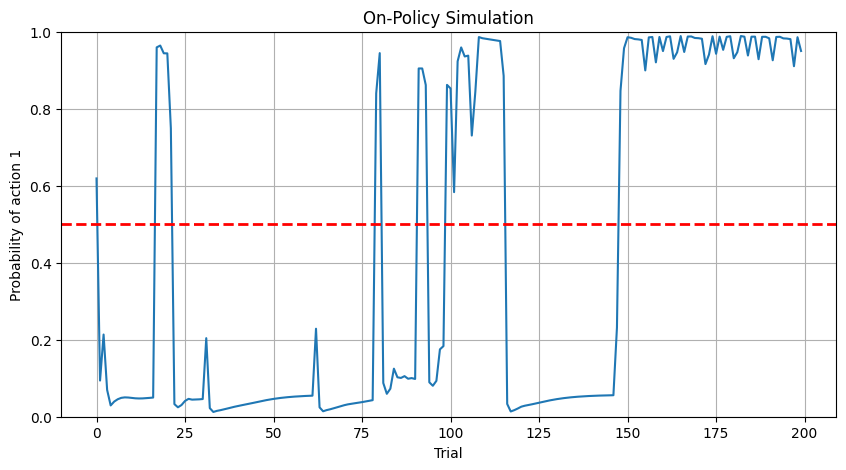

In [30]:
# --------------------------------------------------------------------------
# 6. 온-폴리시(On-policy) 모델 시뮬레이션
# --------------------------------------------------------------------------
print("\n온-폴리시 시뮬레이션 시작...")
model.eval()
with torch.no_grad():
    L_p, R_p = 0.02, 0.3
    n_sim_trials = 200
    
    last_action_onehot = torch.zeros(1, 1, n_actions)
    last_reward = torch.zeros(1, 1, 1)
    rnn_state = torch.zeros(1, 1, hidden_dim)
    
    policies = np.zeros(n_sim_trials)

    for t in range(n_sim_trials):
        reward_action_input = torch.cat([last_reward, last_action_onehot], dim=2)
        
        policy, rnn_state_out = model(reward_action_input, rnn_state)
        
        policies[t] = policy.squeeze()[1].item()
        rnn_state = rnn_state_out.permute(1, 0, 2)

        action = 0 if np.random.random() < policy.squeeze()[0].item() else 1
        
        reward_val = 0
        if action == 0 and np.random.random() < L_p:
            reward_val = 1
        elif action == 1 and np.random.random() < R_p:
            reward_val = 1
            
        last_action_onehot = torch.nn.functional.one_hot(torch.tensor([action]), num_classes=2).unsqueeze(0).float()
        last_reward = torch.tensor([[[reward_val]]], dtype=torch.float32)

    print(f"On-policy 시뮬레이션 200회 시행 후 행동 1 선택 확률 평균: {policies.mean():.4f}")
    
    plt.figure(figsize=(10, 5))
    plt.ylim((0, 1))
    plt.xlabel('Trial')
    plt.ylabel('Probability of action 1')
    plt.title('On-Policy Simulation')
    plt.plot(np.arange(n_sim_trials), policies)
    plt.axhline(y=0.5, linewidth=2, color='red', linestyle="--")
    plt.grid(True)
    plt.show()


In [ ]:
# # 시뮬레이션 파라미터
# n_trials = 100
# n_subjects = 50
# alpha = 0.3
# beta = 5.0

# # 여러 참가자의 데이터 생성 (S x T 차원)
# # 실제 데이터에서는 일부 시행이 -1로 코딩될 수 있으나, 여기서는 모든 시행이 유효하다고 가정합니다.
# all_actions = np.zeros((n_subjects, n_trials))
# all_rewards = np.zeros((n_subjects, n_trials))
# for i in range(n_subjects):
#     a, r = run_sim(alpha, beta, n_trials)
#     all_actions[i, :] = a
#     all_rewards[i, :] = r

# print(f"데이터 생성 완료. 참가자 수: {n_subjects}, 시행 횟수: {n_trials}")
# print(f"Actions shape: {all_actions.shape}, Rewards shape: {all_rewards.shape}")

# # 훈련 데이터와 테스트 데이터 분리
# action_train, action_test, reward_train, reward_test = train_test_split(
#     all_actions, all_rewards, test_size=0.2, random_state=42
# )
# print(f"Train/Test 분리 후 shape: action_train: {action_train.shape}, action_test: {action_test.shape}")
